In [1]:
# Loading Libraries, Remember to run this cell!
library(tidyverse)
library(repr)
library(tidymodels)

options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
# Loading in the data
# Data read from https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS
player_stats <- read_csv("https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS")
colnames(player_stats) <- make.names(colnames(player_stats))

# Cleaning up the dataframe
player_stats_clean <- player_stats %>%
#   Removing players that have retired from the dataset
    filter(is.na(Retired)) %>%
#   Remove unnecessary columns and remove columns with NA values
    select(Backhand, Plays, Turned.Pro, Current.Elo.Rank) %>%
    na.omit() %>%
#   Mutating columns with as_factor()
    mutate(Plays = as_factor(Plays)) %>%
    rename(Dominant.Hand = Plays) %>%
    mutate(Backhand = as_factor(Backhand)) %>%
#   Cleaning up columns with strings and turning them into numeric values
    mutate(Year.Experience = 2020 - Turned.Pro) %>%
    select(-Turned.Pro) %>%
    mutate(Current.Elo.Rank = strtoi(substr(Current.Elo.Rank, 0, nchar(Current.Elo.Rank)-7))) 

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  .default = col_character(),
  X1 = col_double(),
  `Turned Pro` = col_double(),
  Seasons = col_double(),
  Titles = col_double(),
  `Best Season` = col_double(),
  Retired = col_double(),
  Masters = col_double(),
  `Grand Slams` = col_double(),
  `Davis Cups` = col_double(),
  `Team Cups` = col_double(),
  Olympics = col_double(),
  `Weeks at No. 1` = col_double(),
  `Tour Finals` = col_double()
)

See spec(...) for full column specifications.



In [3]:
player_stats

X1,Age,Country,Plays,Wikipedia,Current.Rank,Best.Rank,Name,Backhand,Prize.Money,⋯,Facebook,Twitter,Nicknames,Grand.Slams,Davis.Cups,Web.Site,Team.Cups,Olympics,Weeks.at.No..1,Tour.Finals
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0,26 (25-04-1993),Brazil,Right-handed,Wikipedia,378 (97),363 (04-11-2019),Oscar Jose Gutierrez,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,18 (22-12-2001),United Kingdom,Left-handed,Wikipedia,326 (119),316 (14-10-2019),Jack Draper,Two-handed,"$59,040",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,32 (03-11-1987),Slovakia,Right-handed,Wikipedia,178 (280),44 (14-01-2013),Lukas Lacko,Two-handed,"US$3,261,567",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
497,23 (14-03-1996),Netherlands,Left-handed,Wikipedia,495 (60),342 (05-08-2019),Gijs Brouwer,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
498,24 (17-05-1995),Ukraine,NA,Wikipedia,419 (81),419 (20-01-2020),Vladyslav Orlov,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
499,22 (26-03-1997),Tunisia,Left-handed,Wikipedia,451 (69),408 (24-12-2018),Aziz Dougaz,Two-handed,"$61,984",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


<b>Table 1.0:</b> The original dataframe loaded in.

In [4]:
player_stats_clean

Backhand,Dominant.Hand,Current.Elo.Rank,Year.Experience
<fct>,<fct>,<int>,<dbl>
Two-handed,Right-handed,144,15
Two-handed,Right-handed,100,12
Two-handed,Right-handed,33,5
⋮,⋮,⋮,⋮
Two-handed,Right-handed,143,12
Two-handed,Right-handed,180,11
One-handed,Right-handed,6,9


<b>Table 1.1:</b> Choosing the necessary columns and properfly formatting the values

In [5]:
set.seed(1234) # DO NOT REMOVE
# plotting the two predictors (Current.Elo.Rank and Year.Experience) classifying between Backhand and Dominant.Hand
back_plot <- player_stats_clean %>%
    ggplot(aes(x = Current.Elo.Rank, y = Year.Experience)) +
        geom_point(aes(shape = Backhand, color = Backhand)) +
        labs(x = "Current Elo Rank", y = "Years of Experience",
             shape = "Backhand Type", color = "Backhand Type") +
        ggtitle("Classifying Backhand Type")
                   
dominant_plot <- player_stats_clean %>%
    ggplot(aes(x = Current.Elo.Rank, y = Year.Experience)) +
        geom_point(aes(shape = Dominant.Hand, color = Dominant.Hand)) +
        labs(x = "Current Elo Rank", y = "Years of Experience",
             shape = "Dominant Hand", color = "Dominant Hand") +
        ggtitle("Classifying Dominant Hand")

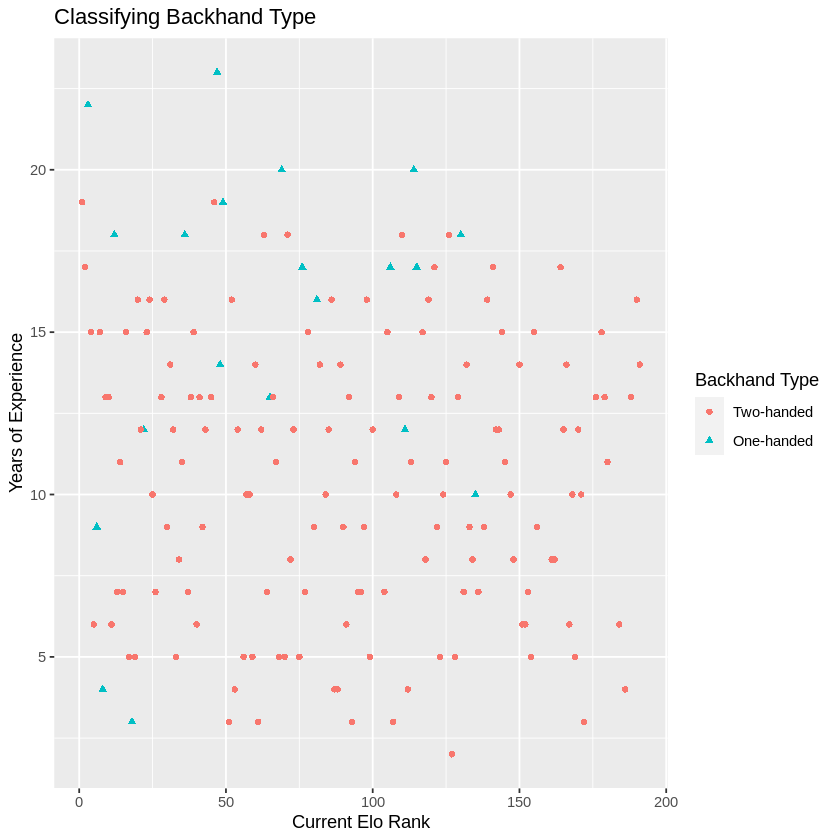

In [6]:
back_plot

<b>Figure 1.0:</b> Plot distinguishing between type of backhand using Current.Elo.Rank as the x-axis and Year.Experience as the y-axis

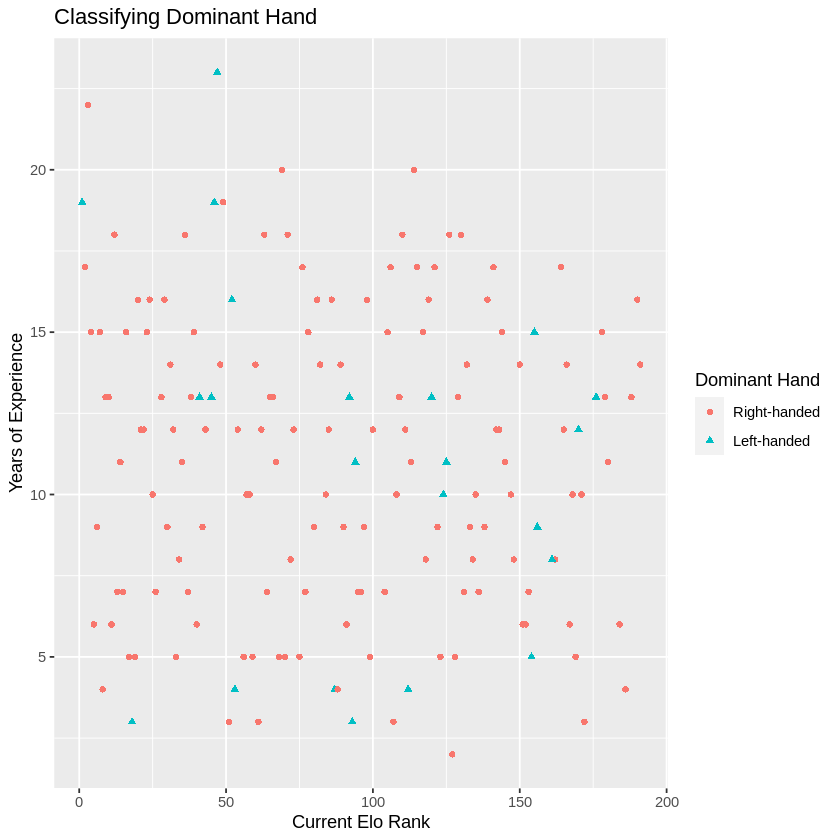

In [7]:
dominant_plot

<b>Figure 1.1:</b> Plot distinguishing between the player's dominant hand using the same variables as <b>Figure 1.0</b>

In [8]:
set.seed(1234) # DO NOT REMOVE
# Making the training and testing splits for each of the predictions
back_split <- initial_split(player_stats_clean, prop = .75, strata = Backhand)
back_training <- training(back_split)
back_testing <- testing(back_split)

dominant_split <- initial_split(player_stats_clean, prop = .75, strata = Dominant.Hand)
dominant_training <- training(dominant_split)
dominant_testing <- testing(dominant_split)

In [9]:
back_training

Backhand,Dominant.Hand,Current.Elo.Rank,Year.Experience
<fct>,<fct>,<int>,<dbl>
Two-handed,Right-handed,144,15
Two-handed,Right-handed,100,12
Two-handed,Right-handed,4,15
⋮,⋮,⋮,⋮
Two-handed,Right-handed,143,12
Two-handed,Right-handed,180,11
One-handed,Right-handed,6,9


<b>Table 2.0:</b> Training dataset used for the backhand classification model.

In [10]:
back_testing

Backhand,Dominant.Hand,Current.Elo.Rank,Year.Experience
<fct>,<fct>,<int>,<dbl>
Two-handed,Right-handed,33,5
Two-handed,Right-handed,51,3
Two-handed,Right-handed,5,6
⋮,⋮,⋮,⋮
Two-handed,Right-handed,28,13
Two-handed,Right-handed,89,14
Two-handed,Right-handed,63,18


<b>Table 2.1:</b> Testing dataset used for the backhand classification model.

In [11]:
dominant_training

Backhand,Dominant.Hand,Current.Elo.Rank,Year.Experience
<fct>,<fct>,<int>,<dbl>
Two-handed,Right-handed,144,15
Two-handed,Right-handed,100,12
Two-handed,Right-handed,51,3
⋮,⋮,⋮,⋮
Two-handed,Right-handed,186,4
Two-handed,Right-handed,180,11
One-handed,Right-handed,6,9


<b>Table 2.2:</b> Training dataset used for the dominant hand classification model.

In [12]:
dominant_testing

Backhand,Dominant.Hand,Current.Elo.Rank,Year.Experience
<fct>,<fct>,<int>,<dbl>
Two-handed,Right-handed,33,5
Two-handed,Right-handed,56,5
Two-handed,Right-handed,31,14
⋮,⋮,⋮,⋮
Two-handed,Right-handed,95,7
Two-handed,Right-handed,70,5
Two-handed,Right-handed,143,12


<b>Table 2.3:</b> Testing dataset used for the dominant classification model.

In [13]:
set.seed(1234) # DO NOT REMOVE
# Creating the Recipes
back_recipe <- recipe(Backhand ~ Current.Elo.Rank + Year.Experience, data = back_training) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

dominant_recipe <- recipe(Dominant.Hand ~ Current.Elo.Rank + Year.Experience, data = dominant_training) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

In [14]:
set.seed(1234)

# Creating the vfolds for cross-validation
back_vfold <- vfold_cv(back_training, v = 5, strata = Backhand)
dominant_vfold <- vfold_cv(dominant_training, v = 5, strata = Dominant.Hand)

In [15]:
set.seed(1234)
# Making the tune spec to choose the best value of k
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
        set_engine("kknn") %>%
        set_mode("classification")

In [16]:
set.seed(1234) # DO NOT REMOVE
# Collecting metrics and filtering for accuracies to determine best value of k
back_accuracies <- workflow() %>%
    add_recipe(back_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = back_vfold, grid = 10) %>%
    collect_metrics %>%
    filter(.metric == "accuracy")

dominant_accuracies <- workflow() %>%
    add_recipe(dominant_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = dominant_vfold, grid = 10) %>%
    collect_metrics %>%
    filter(.metric == "accuracy")

In [17]:
back_accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.7776667,5,0.03682013,Model01
3,accuracy,binary,0.8603333,5,0.03227228,Model02
4,accuracy,binary,0.8603333,5,0.03227228,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
12,accuracy,binary,0.876,5,0.001,Model08
13,accuracy,binary,0.876,5,0.001,Model09
14,accuracy,binary,0.876,5,0.001,Model10


<b>Table 2.4:</b> Table of accuracies of 10 different values of k for the backhand classification model.

In [18]:
dominant_accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.7866667,5,0.024386927,Model1
3,accuracy,binary,0.7873333,5,0.018867962,Model2
5,accuracy,binary,0.8610000,5,0.008573214,Model3
⋮,⋮,⋮,⋮,⋮,⋮,⋮
10,accuracy,binary,0.861,5,0.008573214,Model7
12,accuracy,binary,0.861,5,0.008573214,Model8
14,accuracy,binary,0.861,5,0.008573214,Model9


<b>Table 2.5:</b> Table of accuracies of 10 different values of k for the dominant hand classification model.

In [19]:
set.seed(1234) # DO NOT REMOVE
# plotting accuracies vs value of k for backhand and dominant hand
back_accuracy_vs_k <-ggplot(back_accuracies,aes(x = neighbors, y = mean)) +
  geom_point()+
  geom_line()+
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  ggtitle("Backhand Accuracy") +
  scale_x_continuous(breaks = seq(1, 14, by = 1))

dominant_accuracy_vs_k <-ggplot(dominant_accuracies,aes(x = neighbors, y = mean)) +
  geom_point()+
  geom_line()+
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  ggtitle("Hand Accuracy") +
  scale_x_continuous(breaks = seq(1, 14, by = 1))

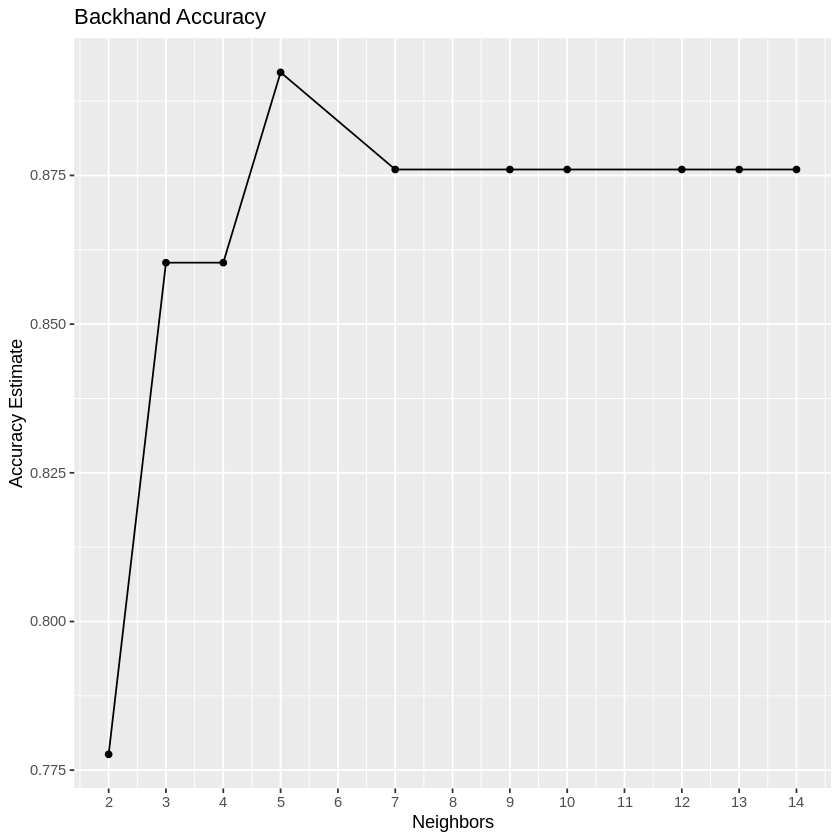

In [20]:
back_accuracy_vs_k

<b>Figure 2.0:</b> Plot of the accuracy vs number of neighbors for the backhand model.

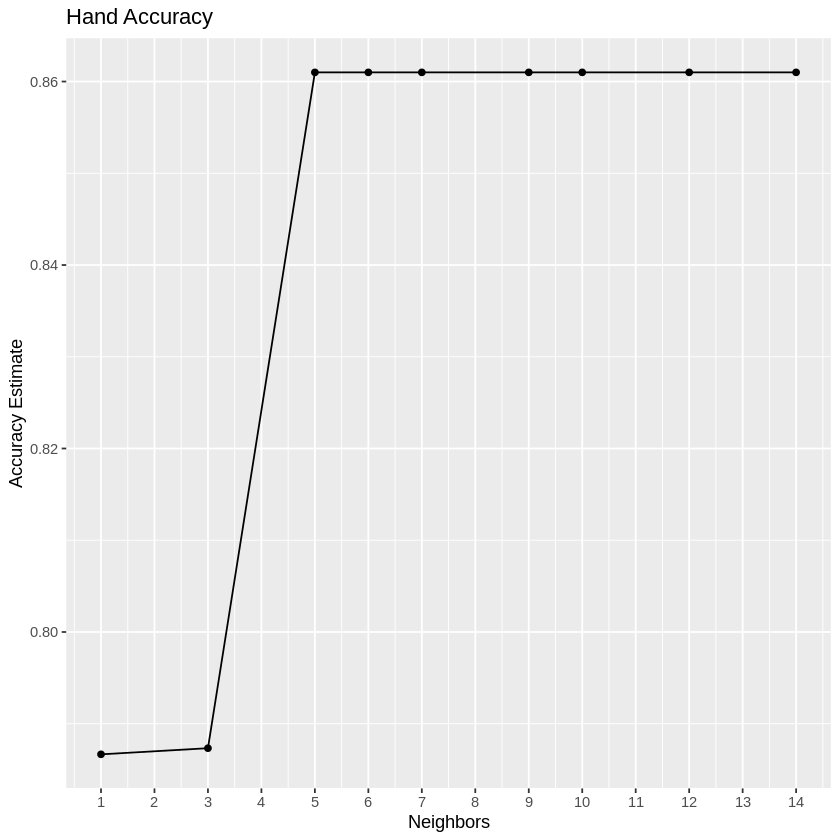

In [21]:
dominant_accuracy_vs_k

<b>Figure 2.1:</b> Plot of the accuracy vs number of neighbors for the dominant hand model.

In [22]:
set.seed(1234) # DO NOT REMOVE
# Chose k = 12 for backhand, k = 5 for dominant hand
back_best_k <- nearest_neighbor(weight_func = "rectangular", neighbors = 12) %>%
    set_engine("kknn") %>%
    set_mode("classification")

dominant_best_k <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) %>%
    set_engine("kknn") %>%
    set_mode("classification")

back_fit <- workflow() %>%
    add_recipe(back_recipe) %>%
    add_model(back_best_k) %>%
    fit(data = back_training)

dominant_fit <- workflow() %>%
    add_recipe(dominant_recipe) %>%
    add_model(dominant_best_k) %>%
    fit(data = dominant_training)

In [23]:
set.seed(1234) # DO NOT REMOVE
# Making predictions using the classification model on the testing dataset
back_predictions <- back_fit %>%
    predict(back_testing) %>%
    bind_cols(back_testing) 

back_accuracy <- back_predictions %>%
    metrics(truth = Backhand, estimate = .pred_class)

dominant_predictions <- dominant_fit %>%
    predict(dominant_testing) %>%
    bind_cols(dominant_testing)

dominant_accuracy <- dominant_predictions %>%
    metrics(truth = Dominant.Hand, estimate = .pred_class)

In [24]:
back_predictions

.pred_class,Backhand,Dominant.Hand,Current.Elo.Rank,Year.Experience
<fct>,<fct>,<fct>,<int>,<dbl>
Two-handed,Two-handed,Right-handed,33,5
Two-handed,Two-handed,Right-handed,51,3
Two-handed,Two-handed,Right-handed,5,6
⋮,⋮,⋮,⋮,⋮
Two-handed,Two-handed,Right-handed,28,13
Two-handed,Two-handed,Right-handed,89,14
Two-handed,Two-handed,Right-handed,63,18


<b>Table 3.0:</b> Testing dataset with the prediction of the type of backhand made by the classification model.

In [25]:
dominant_predictions

.pred_class,Backhand,Dominant.Hand,Current.Elo.Rank,Year.Experience
<fct>,<fct>,<fct>,<int>,<dbl>
Right-handed,Two-handed,Right-handed,33,5
Right-handed,Two-handed,Right-handed,56,5
Right-handed,Two-handed,Right-handed,31,14
⋮,⋮,⋮,⋮,⋮
Right-handed,Two-handed,Right-handed,95,7
Right-handed,Two-handed,Right-handed,70,5
Right-handed,Two-handed,Right-handed,143,12


<b>Table 3.1:</b> Testing dataset with the prediction of the player's dominant hand made by the classification model

In [26]:
set.seed(1234) # DO NOT REMOVE
# Calculating the accuracy of the predictions the classification model made
back_accuracy <- back_predictions %>%
    metrics(truth = Backhand, estimate = .pred_class) %>%
    filter(.metric == "accuracy") %>%
    select(.estimate) %>%
    pull()

dominant_accuracy <- dominant_predictions %>%
    metrics(truth = Dominant.Hand, estimate = .pred_class) %>%
    filter(.metric == "accuracy") %>%
    select(.estimate) %>%
    pull()

In [27]:
print(paste("Accuracy of the backhand classification model: ", back_accuracy))
print(paste("Accuracy of the dominant hand classification model: ", dominant_accuracy))

[1] "Accuracy of the backhand classification model:  0.875"
[1] "Accuracy of the dominant hand classification model:  0.871794871794872"
